# Dask DataFrame

Материалы: 
* Макрушин С.В. Лекция 13: Dask DataFrame
* https://docs.dask.org/en/latest/dataframe.html
* Jesse C. Daniel. Data Science with Python and Dask. 

## Задачи для совместного разбора

1. Считать данные из файлов в каталоге `accounts`. Содержат ли какие-либо из столбцов пропуски?

2. Подсчитать количество раз, которое то или иное имя встретилось в выборке. Вывести самое часто встречающееся имя.

3. Создать новую колонку, которая является результатом от деления значения `amount` нацело на 100, если `amount` > 100, и нулём в противном случае.

## Лабораторная работа 13

__При решении данных задач не подразумевается использования других коллекций, кроме `dask.DataFrame`, если в задании явно не указано обратное.__

In [ ]:
pip install fsspec

     |████████████████████████████████| 132 kB 4.9 MB/s 


In [ ]:
import dask.dataframe as dd
import dask.array as da
import pandas as pd
import dask.bag as db
import json
import dask.bag as db
import dask

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. В архиве `recipes_full.zip` находятся файлы, содержащие информацию об рецептах блюд. Загрузите данные из файлов этого архива в виде `dd.DataFrame` с названием `recipes`. Укажите, что в столбце `submitted` содержатся даты.

In [ ]:
Output = dd.read_csv("/content/drive/MyDrive/Colab Notebooks/lab 13/recipes_full/recipes_full_*.csv", dtype={'minutes': 'float64','n_steps': 'float64'} )

Output['submitted']=dd.to_datetime(Output['submitted'])


2. Выведите метаинформацию о таблице: `npartitions` и типы столбцов.

In [ ]:
Output

,id,name,minutes,contributor_id,submitted,n_steps,description,n_ingredients
npartitions=16,,,,,,,,
,int64,object,float64,int64,datetime64[ns],float64,object,int64
,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


In [ ]:
Output.npartitions

16

3. Выведите на экран 5 первых строк таблицы. Выведите на экран 5 последних строк таблицы. В случае сообщения об ошибки объясните причину и исправьте ошибку.

In [ ]:
Output_Final=Output.compute()

In [ ]:
Output_Final.head(5)
Output.tail(5)

,id,name,minutes,contributor_id,submitted,n_steps,description,n_ingredients
44011,1029131,tuti waffle snackies steakhouse,19.0,171345,1973-10-18,4.0,"according to a providence journal article, ama...",4
44012,1700703,noelias cheats crocante fleisch zitumbuwa,1.0,30228,2007-07-01,6.0,if possible sauté the onions and garlic in abo...,1
44013,1910650,rubbed restuffed pelmeni bedouin flavourful,60.0,591905,2009-09-26,3.0,another great recipe to add to the growing swe...,2
44014,713836,stems polpettine peezi,NaN,357389,2003-09-30,4.0,adapted from top secret recipes. love this!,9
44015,660699,clementines,64.0,29196,1973-06-03,6.0,this would make a great start to your holiday ...,8


4. Посчитайте, сколько строк содержит каждый из блоков (partitions).

In [ ]:
# Output_Final.count(axis='columns') 
# tt=Output.count(axis='columns')
# print (tt.compute())


Output.map_partitions(len).compute()

0     237505
1      41450
2     235222
3      43733
4     238139
5      40816
6     234750
7      44205
8     237887
9      41068
10    234486
11     44468
12    238298
13     40656
14    234938
15     44016
dtype: int64

5. Найдите максимум в столбце `n_steps`. Визуализируйте граф вычислений для этой задачи. Прокомментируйте логику работы `dask` при решении данной задачи.

In [ ]:
print(Output.max(axis=0))
col=Output["n_steps"].compute()
col.max()
da.max(col).compute()

Dask Series Structure:
npartitions=1
contributor_id    object
submitted            ...
dtype: object
Dask Name: dataframe-max-agg, 113 tasks


ValueError: ignored

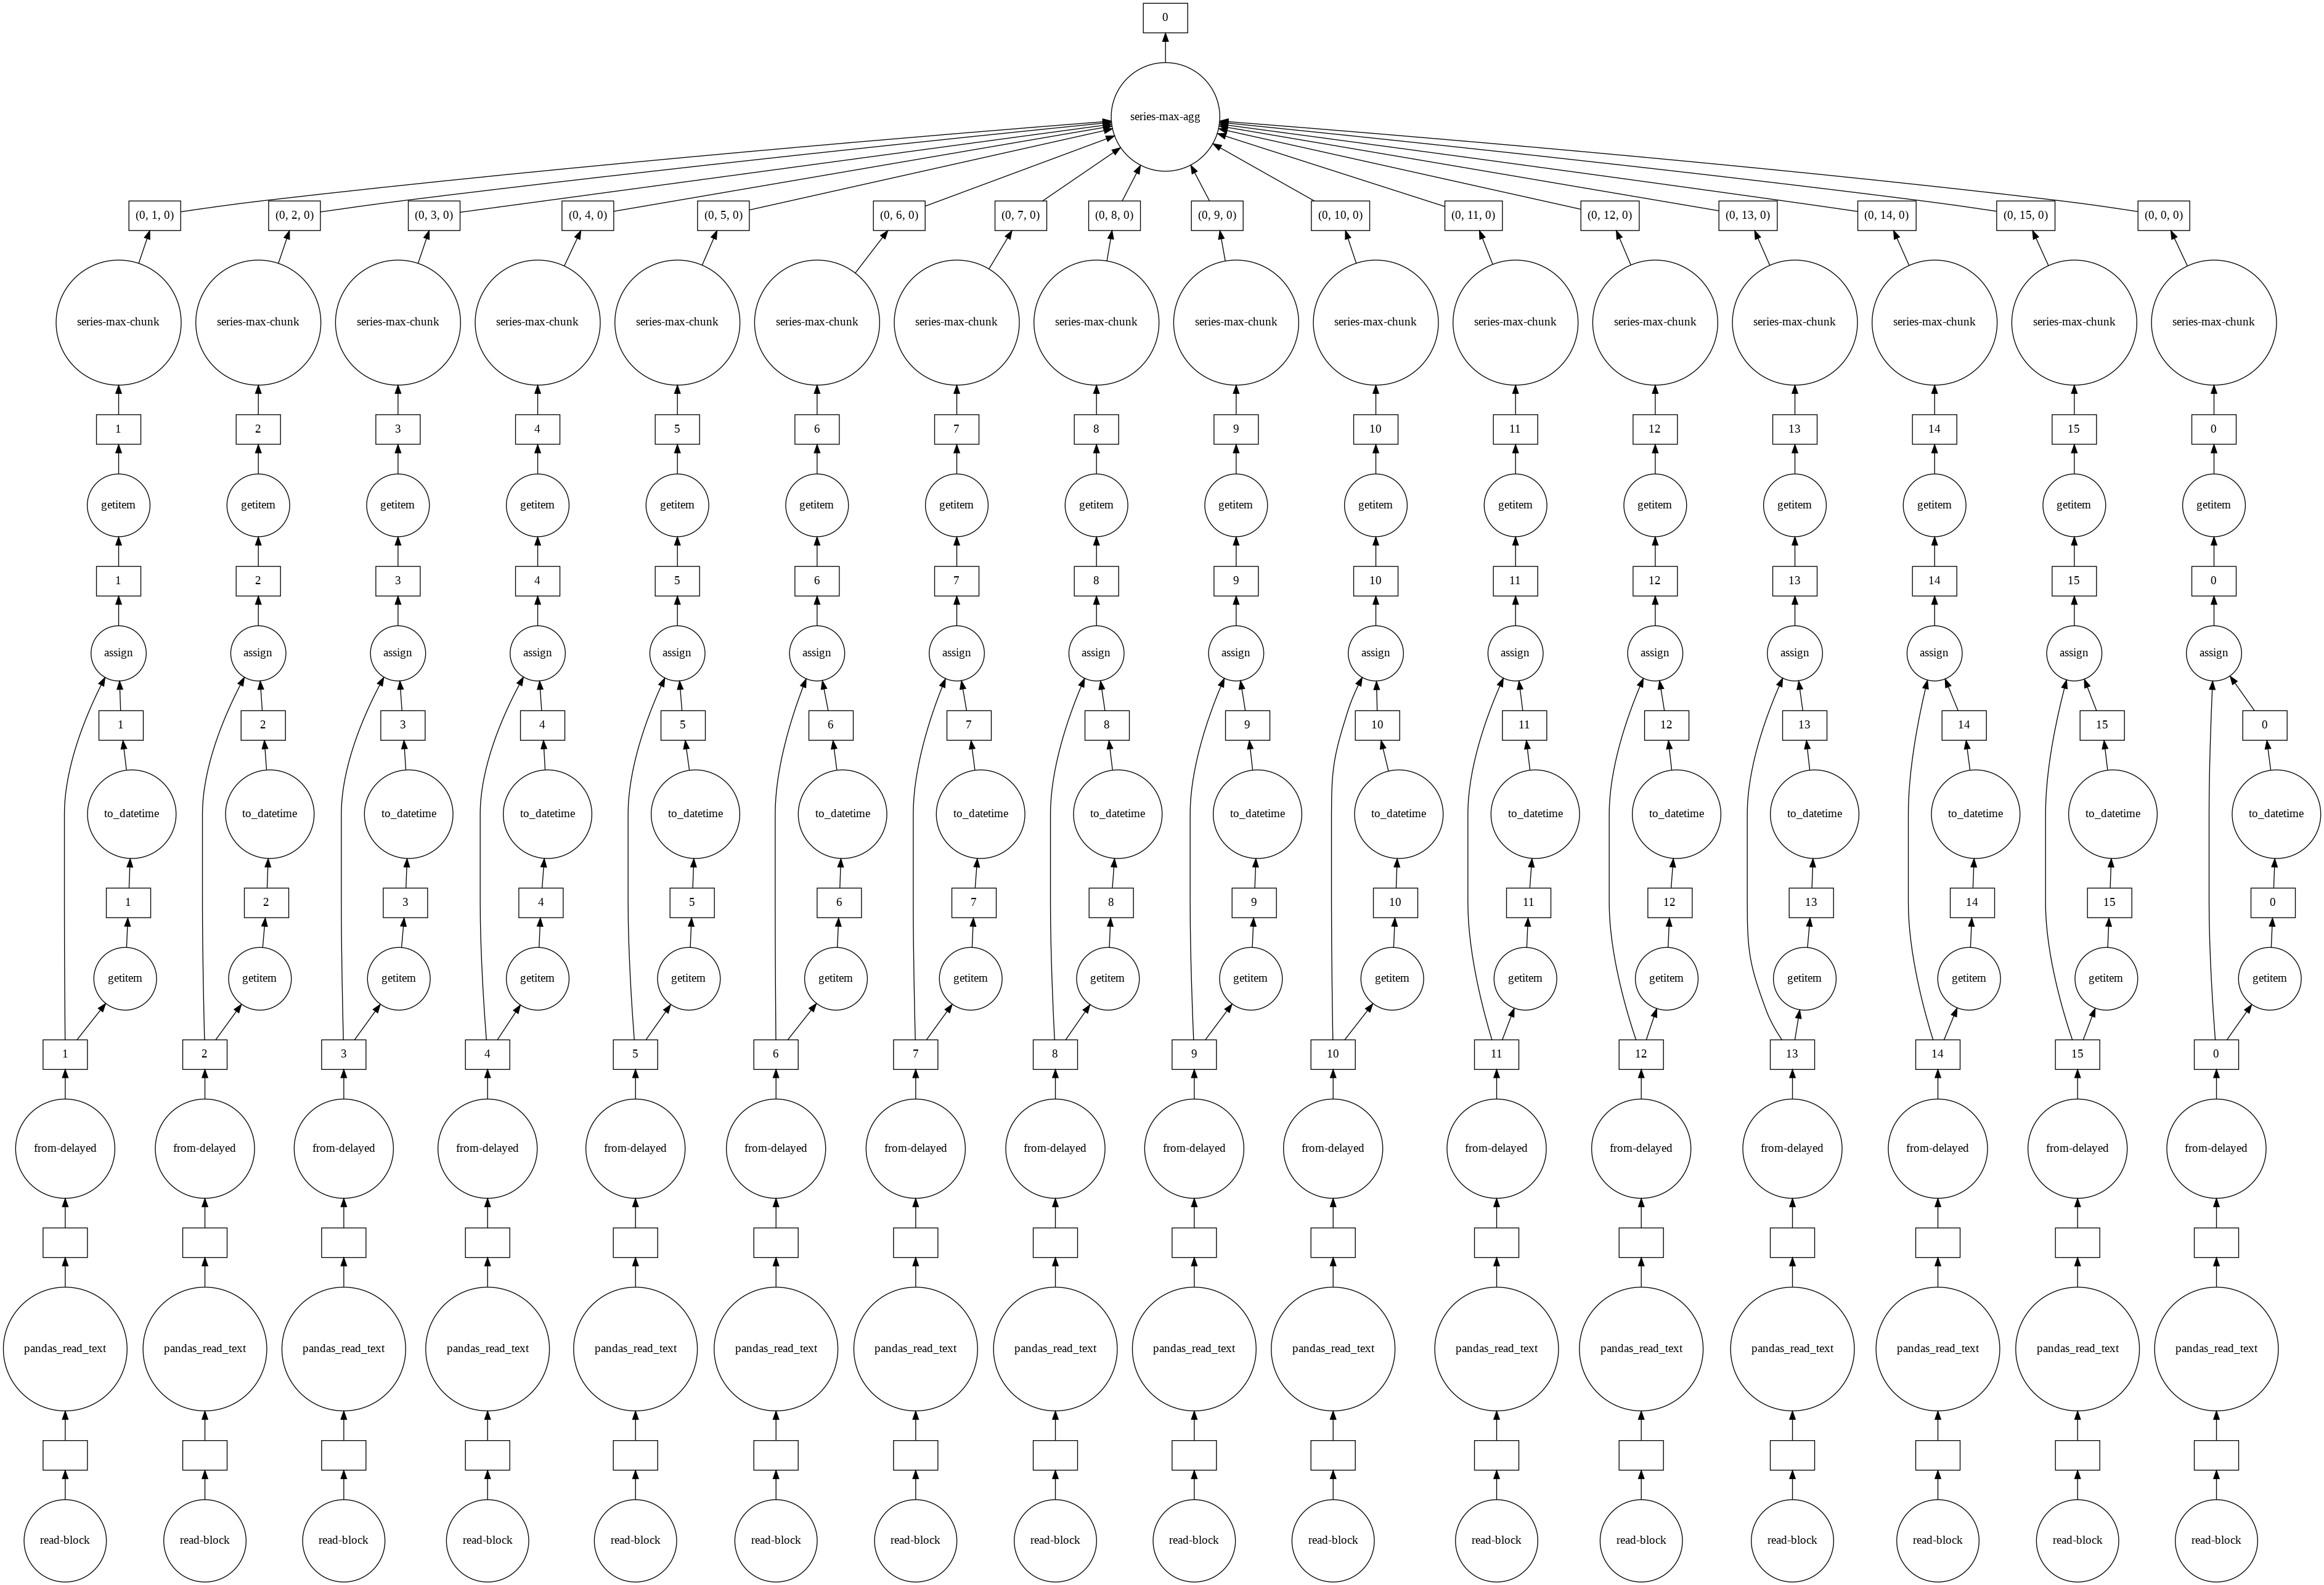

In [ ]:
Output.n_steps.max().visualize()

In [ ]:
Output.n_steps.max().compute()

145.0

6. Посчитайте количество рецептов с группировкой по месяцам добавления отзыва в базу.

In [ ]:
Output.groupby("submitted").size().compute()


submitted
1970-01-01    110
1970-01-02    116
1970-01-03    101
1970-01-04    103
1970-01-05    106
             ... 
2021-08-08    105
2021-08-09    107
2021-08-10    111
2021-08-11     94
2021-08-12     79
Length: 18852, dtype: int64

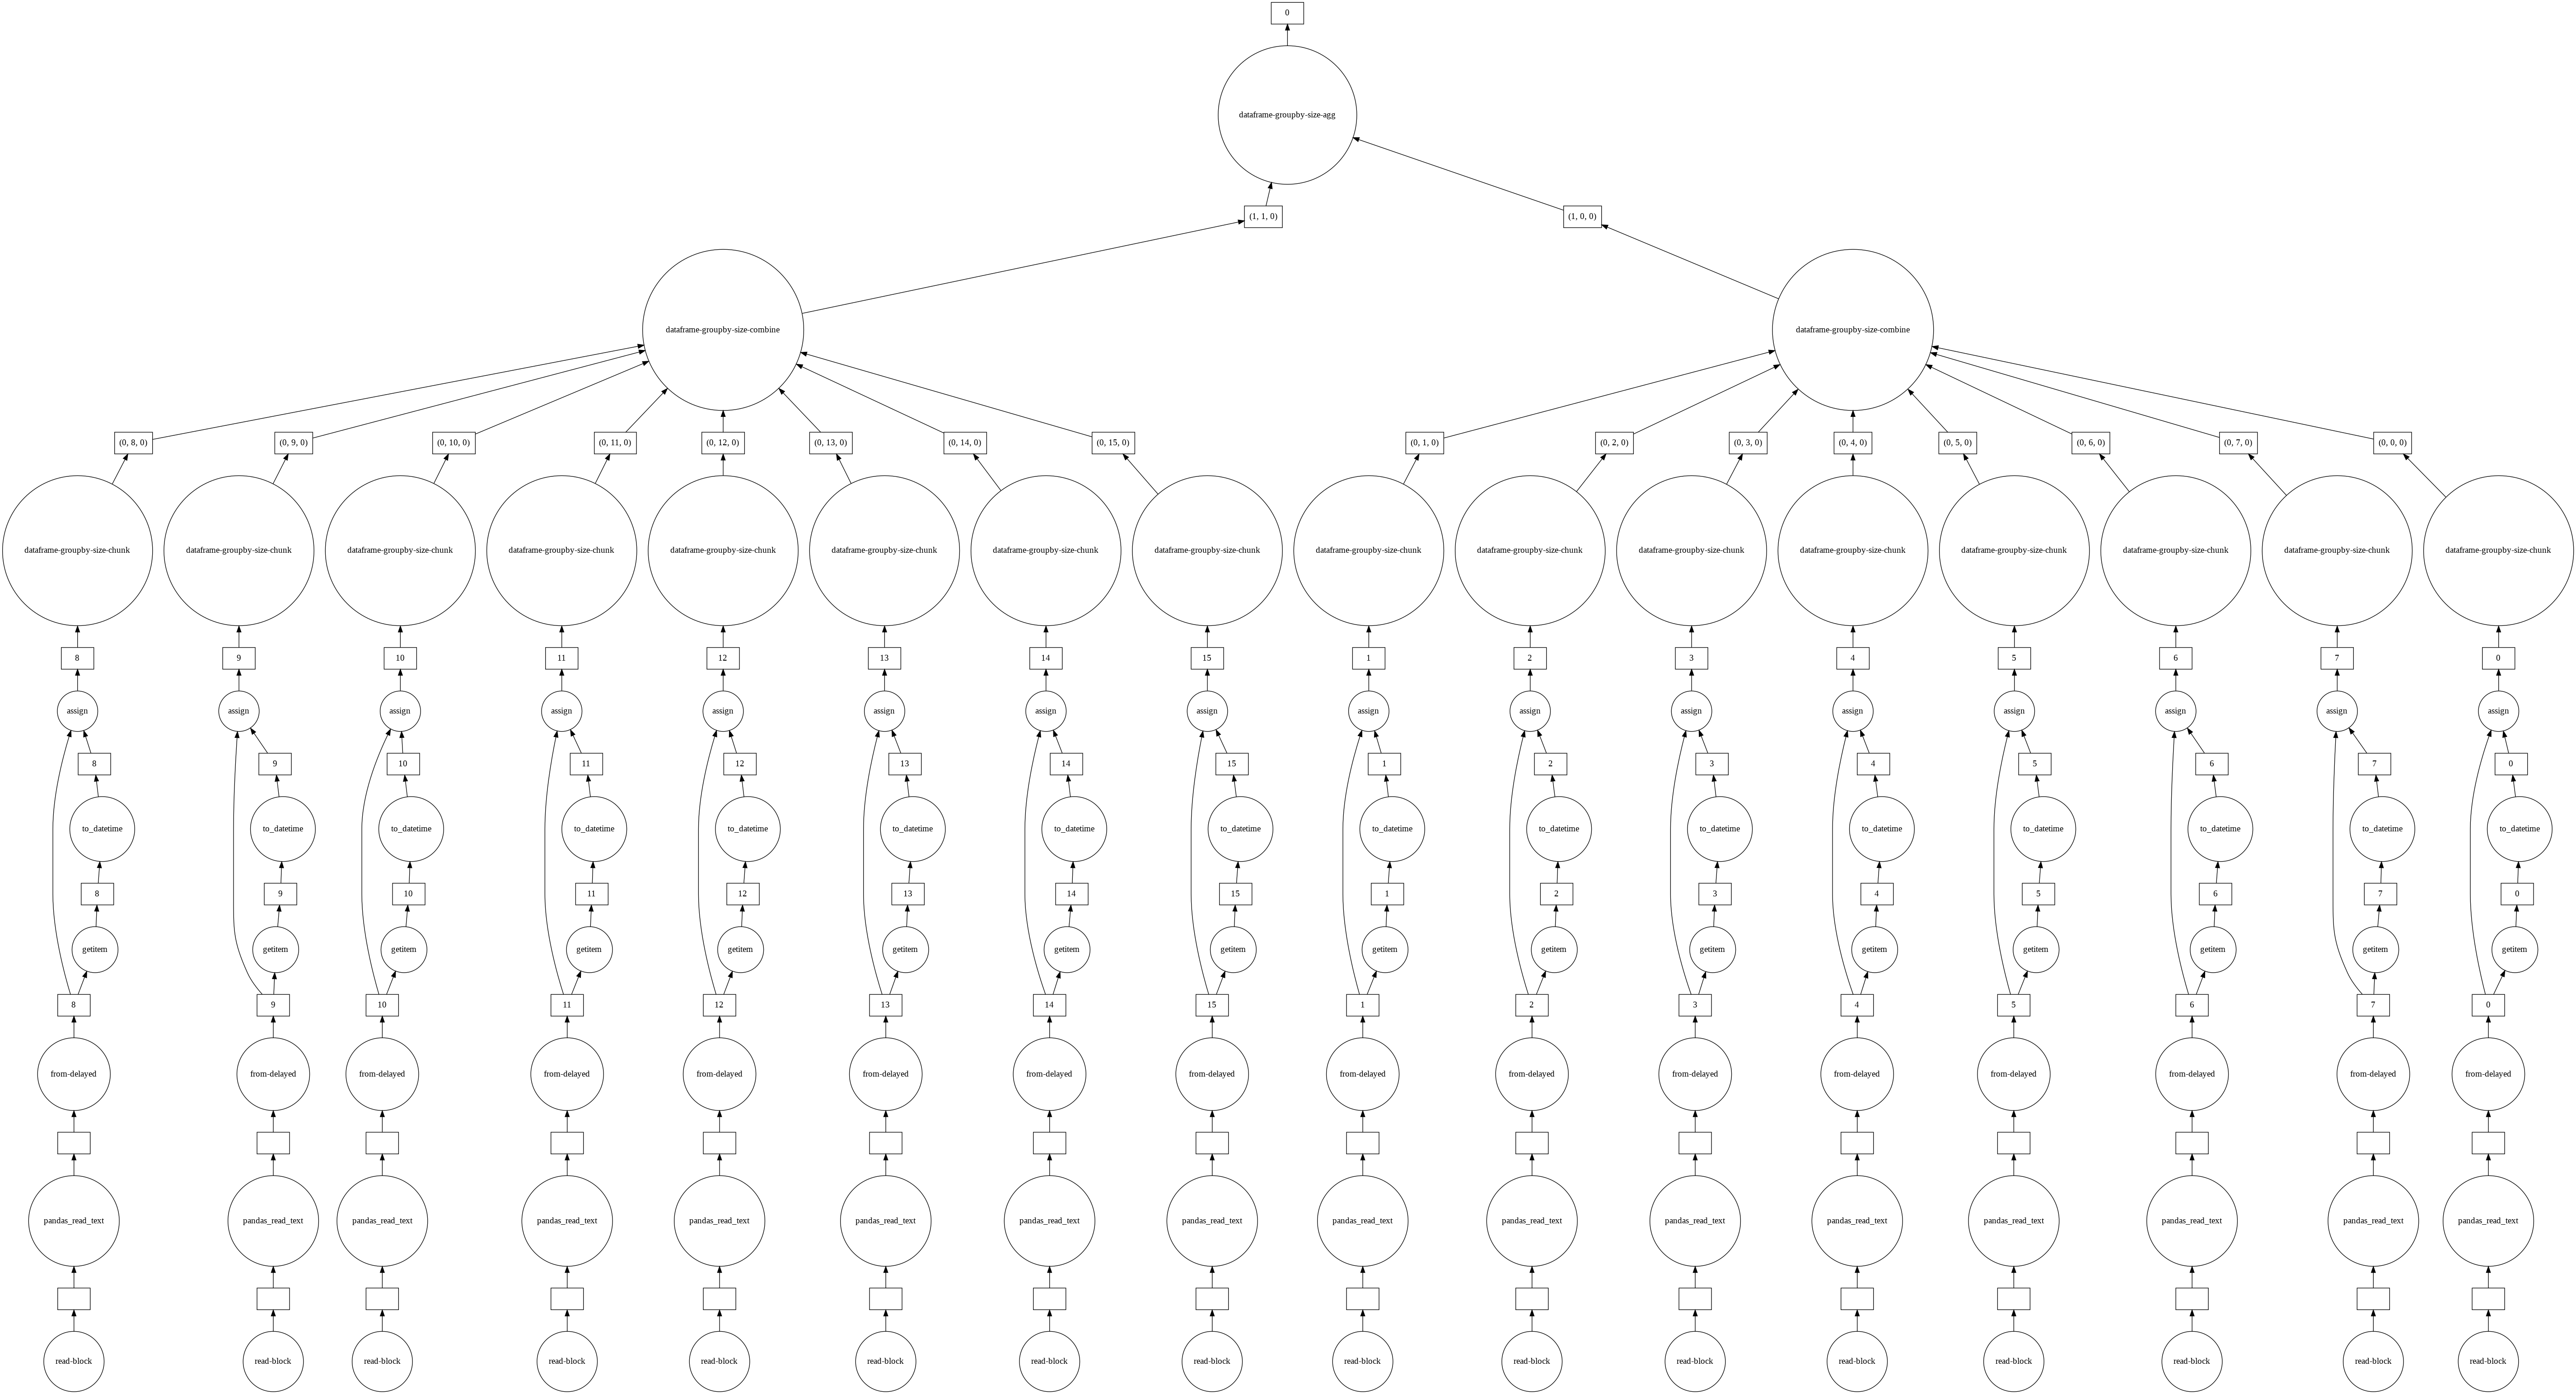

In [ ]:
Output.groupby("submitted").size().visualize()


In [ ]:
gdr = Output["submitted"].groupby(Output.submitted.dt.month).agg('count').compute() #sum 2 231 637
gdr

submitted
1     193363
2     173834
3     192389
4     186049
5     192487
6     184205
7     189337
8     187276
9     181081
10    187018
11    180974
12    183624
Name: submitted, dtype: int64

In [ ]:
gdr = Output.groupby(Output.submitted.dt.strftime('%m')).id.count().compute() #sum 2 231 637
gdr

submitted
01    193363
02    173834
03    192389
04    186049
05    192487
06    184205
07    189337
08    187276
09    181081
10    187018
11    180974
12    183624
Name: id, dtype: int64

7. Считайте файлы из архива `reviews_full.zip` (__ЛР12__) в виде `dask.bag`. Пользуясь результатом лабораторной работы 12, рассчитайте среднее значение оценок отзывов с группировкой по месяцам. После завершения всех вычислений преобразуйте результат к `pd.Series`.

In [ ]:
def rating(JSONS):
  res = json.loads(JSONS[0])
  res.update({'rating':int(JSONS[1][-6])})
  res.update({'month':res['date'][5:7]})
  return res

In [ ]:
output_with_rating = db.read_text(f'/content/drive/MyDrive/Colab Notebooks/lab 12/reviews_*.json', include_path=True).map(rating)

In [ ]:
def summa(total, value):
    return total + value['rating']

def combo(left, right):
    return left + right

res_7_1 = output_with_rating.foldby(lambda var: var['month'], summa, 0, combo, 0).compute()
res_7_1

[('05', 3443183),
 ('06', 3425742),
 ('11', 3190996),
 ('09', 3132019),
 ('10', 3270977),
 ('04', 3324346),
 ('02', 3094351),
 ('03', 3410689),
 ('12', 3320539),
 ('01', 3416161),
 ('07', 3559810),
 ('08', 3362237)]

In [ ]:
pip install partd

In [ ]:
def modify_dict(output_with_rating, out_71, out_72):
  res_7_2 = output_with_rating.pluck('month').frequencies().compute()
  lists = list(map((lambda x, y: {x[0]:x[1] / y[1]}), out_71, out_72))
  return (dict((key, val) for k in lists for key, val in k.items()))


mean_rating = pd.Series(modify_dict(output_with_rating))

In [ ]:
import datetime
import re
def binop(a):
    #print (a)
    datem = datetime.datetime.strptime(a['date'], "%Y-%m-%d")
    return datem.month

output_with_rating.groupby(binop).compute()

In [ ]:
b['mon'] = b['date'].dt.to_period('M')
b["review"]=b["review"].astype(int)
print(b)

d = b.groupby('mon')["review"].mean().compute()
d

8. Пользуясь результатами решения задач 6 и 7, создайте `pd.DataFrame`, содержащий два столбца: `mean_rating`, `recipes_count`

In [ ]:
final = pd.DataFrame(mean_rating, columns=['mean_rating'])
final['recipes_count'] = gdr
final

,mean_rating,recipes_count
05,4.415401,192487
06,4.418419,184205
11,4.408829,180974
09,4.410661,181081
10,4.411452,187018
04,4.412259,186049
02,4.407135,173834
03,4.406911,192389
12,4.406908,183624
01,4.408553,193363
